In [1]:
# 以沪深300数据集为例，构建特征和目标值，拟合特征与目标值，并评估模型
# 数据已经经过了初步清洗，剔除掉每天的涨跌停股和ST股，并使用后复权价格
# 如果不做回测，可以注释掉一切带"_test"的行

import pandas as pd
from scutquant import scutquant, alpha

In [2]:
# 读取数据
df_train = pd.read_csv('D:/Desktop/CSI300.csv')
df_test = pd.read_csv('D:/Desktop/CSI300_test.csv')
df_train.set_index(['datetime', 'instrument'], inplace=True)
df_test.set_index(['datetime', 'instrument'], inplace=True)

df = pd.concat([df_train, df_test], axis=0)

#sup_data = pd.read_csv('D:/Desktop/SH000300.csv')  # supplemental_data
#df = scutquant.join_data(df, sup_data, time='datetime', col=['idx_close'], index=['datetime', 'instrument'])
df

open       close        high         low  \
datetime   instrument                                                   
2010-01-04 300003.SZ    51.590000   51.500000   51.850000   51.100000   
           300014.SZ    39.700000   39.470000   39.900000   39.240000   
           300015.SZ    48.970000   48.770000   49.190000   48.550000   
           300033.SZ    72.010000   74.570000   76.060000   71.610000   
           600000.SH    64.829142   62.928517   64.947931   62.839425   
...                           ...         ...         ...         ...   
2022-12-23 688363.SH   130.338644  130.842543  133.513211  129.078895   
           688396.SH    53.248294   52.735905   54.052042   52.344078   
           688561.SH    61.590000   67.160000   68.190000   61.590000   
           688599.SH    55.856185   54.938671   56.263968   53.909017   
           688981.SH    40.900000   41.060000   41.330000   40.830000   

                           volume        amount  
datetime   instrument                            
2010-01-04 300003.SZ     842437.0  4.328901e+07  
           300014.SZ     727706.0  2.873182e+07  
           300015.SZ     740314.0  3.613862e+07  
           300033.SZ    3627417.0  2.702477e+08  
           600000.SH   66191338.0  1.419984e+09  
...                           ...           ...  
2022-12-23 688363.SH    2334792.0  3.036193e+08  
           688396.SH    3462319.0  1.820840e+08  
           688561.SH    3554834.0  2.353862e+08  
           688599.SH   10072858.0  5.395502e+08  
           688981.SH    7428877.0  3.055459e+08  

[651282 rows x 6 columns]

In [3]:
# 清洗数据(由于原始数据已经经过了初步清洗，所以以下步骤可以省去)

# 查看缺失值和数据类型
df.info()
# 查看是否存在异常数据
#df.describe()
# 处理缺失值
#df.dropna(axis=1, how='all', inplace=True)  # 去除掉全为缺失值的列
#df = df.groupby(['instrument']).fillna(method='ffill').dropna()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 651282 entries, ('2010-01-04', '300003.SZ') to ('2022-12-23', '688981.SH')
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    651282 non-null  float64
 1   close   651282 non-null  float64
 2   high    651282 non-null  float64
 3   low     651282 non-null  float64
 4   volume  651282 non-null  float64
 5   amount  651282 non-null  float64
dtypes: float64(6)
memory usage: 32.4+ MB


In [4]:
# 下面开始构造目标值和特征

df['label'] = scutquant.price2ret(df['close'], shift1=-1, shift2=-2, groupby='instrument')

feature_kwargs = {
    'data': df,
    'open': 'open',
    'close': 'close',
    'high': 'high',
    'low': 'low',
    'volume': 'volume',
    'amount': 'amount',
    'groupby': 'instrument'
}
features = alpha.alpha360(feature_kwargs, shift=60)  # 请使用自己的因子库以获得更好的表现
X = pd.concat([features, df['label']], axis=1)

# 伪市场因子,需要读取supplemental data
#df['idx_ret'] = scutquant.price2ret(df['idx_close'], shift1=1, shift2=0, groupby='instrument')
#X['market'] = df['idx_ret'] / df['close']
X.describe()

,open1,open2,open3,open4,open5,open6,open7,open8,open9,open10,...,amount52,amount53,amount54,amount55,amount56,amount57,amount58,amount59,amount60,label
count,650972.000000,650662.000000,650352.000000,650042.000000,649732.000000,649422.000000,649112.000000,648802.000000,648492.000000,648182.000000,...,6.351620e+05,6.348520e+05,6.345420e+05,6.342320e+05,6.339220e+05,6.336120e+05,6.333020e+05,6.329920e+05,6.326820e+05,650662.000000
mean,238.836332,238.779686,238.724076,238.665882,238.604631,238.544074,238.482443,238.421673,238.360657,238.299031,...,6.565058e+08,6.565103e+08,6.565589e+08,6.565841e+08,6.566470e+08,6.566969e+08,6.567347e+08,6.567624e+08,6.567835e+08,0.001135
std,649.255725,649.117089,648.986637,648.843061,648.688461,648.541004,648.384503,648.243697,648.103997,647.964390,...,1.162829e+09,1.162937e+09,1.163101e+09,1.163247e+09,1.163431e+09,1.163624e+09,1.163804e+09,1.163969e+09,1.164108e+09,0.040568
min,1.593503,1.593503,1.593503,1.593503,1.593503,1.593503,1.593503,1.593503,1.593503,1.593503,...,4.817397e+05,4.817397e+05,4.817397e+05,4.817397e+05,4.817397e+05,4.817397e+05,4.817397e+05,4.817397e+05,4.817397e+05,-0.800138
25%,19.002829,19.001716,19.000000,19.000000,18.998313,18.997022,18.993247,18.990386,18.989289,18.987988,...,1.252947e+08,1.252703e+08,1.252531e+08,1.252307e+08,1.252177e+08,1.251812e+08,1.251491e+08,1.251195e+08,1.250882e+08,-0.012942
50%,67.552479,67.539196,67.523113,67.509189,67.494513,67.479295,67.463146,67.446048,67.428986,67.414553,...,2.959660e+08,2.959143e+08,2.959028e+08,2.958845e+08,2.958751e+08,2.958558e+08,2.958358e+08,2.958129e+08,2.957821e+08,0.000000
75%,205.666743,205.622031,205.576891,205.543096,205.502342,205.469763,205.422188,205.390568,205.355650,205.321390,...,6.967757e+08,6.967394e+08,6.967841e+08,6.967614e+08,6.967914e+08,6.968196e+08,6.968587e+08,6.968459e+08,6.968023e+08,0.012839
max,16995.086560,16995.086560,16995.086560,16995.086560,16995.086560,16995.086560,16995.086560,16995.086560,16995.086560,16995.086560,...,4.969251e+10,4.969251e+10,4.969251e+10,4.969251e+10,4.969251e+10,4.969251e+10,4.969251e+10,4.969251e+10,4.969251e+10,5.026166


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 580608 entries, ('2010-01-04', '300003.SZ') to ('2021-12-31', '688981.SH')
Columns: 361 entries, open1 to label
dtypes: float64(361)
memory usage: 1.6+ GB
None
X_mis= 1.6134781779619614
clean dataset done 

pop label done 

label norm done 



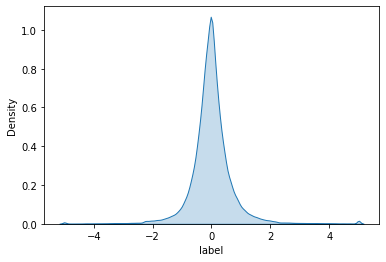

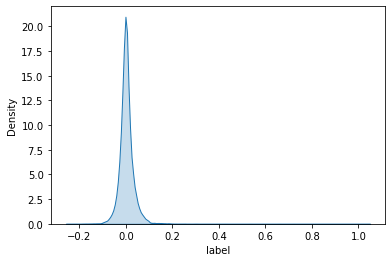

norm data done 

all works done 



,open1,open2,open3,open4,open5,open6,open7,open8,open9,open10,...,amount51,amount52,amount53,amount54,amount55,amount56,amount57,amount58,amount59,amount60
count,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,...,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000,449703.000000
mean,-0.027539,-0.027534,-0.027529,-0.027525,-0.027520,-0.027515,-0.027509,-0.027504,-0.027498,-0.027492,...,-0.022504,-0.022514,-0.022516,-0.022524,-0.022550,-0.022561,-0.022573,-0.022593,-0.022609,-0.022660
std,0.712335,0.712404,0.712483,0.712559,0.712645,0.712727,0.712805,0.712868,0.712932,0.712984,...,0.759376,0.759109,0.758930,0.758704,0.758420,0.758164,0.757926,0.757417,0.757199,0.756354
min,-0.387791,-0.387845,-0.387908,-0.387969,-0.388035,-0.388094,-0.388154,-0.388203,-0.388250,-0.388288,...,-0.493444,-0.493303,-0.493176,-0.493057,-0.492843,-0.492678,-0.492523,-0.492136,-0.491922,-0.491027
25%,-0.350844,-0.350867,-0.350903,-0.350932,-0.350966,-0.350996,-0.351026,-0.351045,-0.351060,-0.351068,...,-0.399278,-0.399145,-0.399027,-0.398922,-0.398747,-0.398595,-0.398457,-0.398148,-0.397989,-0.397343
50%,-0.262450,-0.262439,-0.262466,-0.262454,-0.262470,-0.262489,-0.262493,-0.262494,-0.262497,-0.262491,...,-0.274940,-0.274786,-0.274671,-0.274561,-0.274416,-0.274269,-0.274161,-0.273937,-0.273838,-0.273475
75%,-0.039317,-0.039363,-0.039453,-0.039497,-0.039486,-0.039465,-0.039482,-0.039556,-0.039580,-0.039631,...,0.005996,0.006036,0.006090,0.006119,0.006148,0.006141,0.006154,0.006182,0.006201,0.005914
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [5]:
# 先拆分出测试集，然后做特征工程、数据清洗，并根据mutual information score选择特征

X_test = X[X.index.isin(df_test.index)]
X = X[~X.index.isin(df_test.index)]

# 使用auto_process()自动处理训练集和验证集(将在以后的版本完善拆分数据集的函数，使其能够同时处理训练、验证和测试集)
# select需要消耗大量时间，但可以过滤掉噪声。使用时需要在时间开销和模型性能之间权衡
x_train, x_valid, y_train, y_valid, ymean, ystd = scutquant.auto_process(X, 'label', groupby='instrument', select=False, orth=False)
x_train.describe()

In [6]:
# 手动处理测试集
X_test = X_test.groupby(['instrument']).fillna(method='ffill').dropna()
x_test = X_test.copy()
y_test = x_test.pop('label')
col = x_train.columns
x_test = x_test[col]
x_test = scutquant.zscorenorm(x_test)

In [7]:
# 拟合模型
model1 = scutquant.auto_lgbm(x_train, y_train, x_valid, (y_valid-ymean)/ystd)
model2 = scutquant.auto_lrg(x_train, y_train,  method='ridge')

pred1 = model1.predict(x_test)
pred2 = model2.predict(x_test)
pred = []
for i in range(len(pred1)):
    pred.append(0.5 * pred1[i] + 0.5 * pred2[i])
pred = pd.DataFrame(pred, columns=["predict"], index=x_test.index)
pred += ymean
pred *= ystd
pred.describe()

Training until validation scores don't improve for 30 rounds
[20]	train's l2: 0.581891	valid's l2: 0.477757
Early stopping, best iteration is:
[4]	train's l2: 0.582555	valid's l2: 0.477696
ridge method will be used


,predict
count,70552.000000
mean,-0.000363
std,0.001313
min,-0.020231
25%,-0.000757
50%,-0.000294
75%,0.000077
max,0.015615


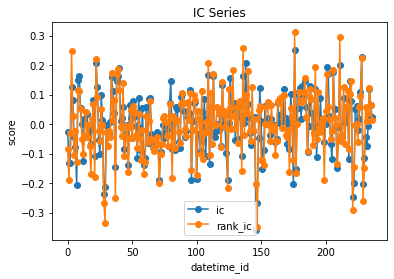

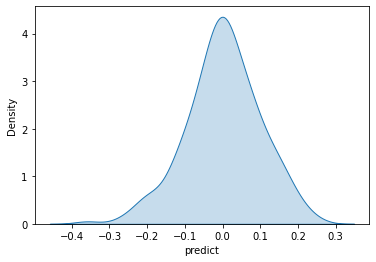

ic= 0.001752123449002882 icir= 0.0177249559843333 rank_ic= -0.00029983867572200783 rank_icir= -0.0027800330934434517


0.010271404257619826

In [8]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = scutquant.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = scutquant.pearson_corr(pred.values, y_test)
r[0]

In [9]:
# 以下为回测部分
from scutquant import executor, report

# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, time='datetime', price='close', volume='volume')

Accuracy of Prediction: 0.5252296178705068


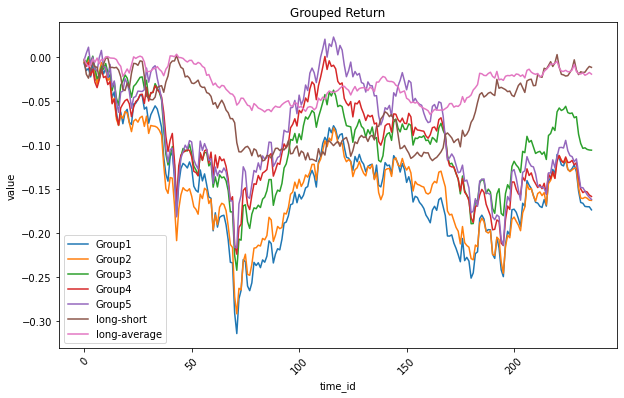

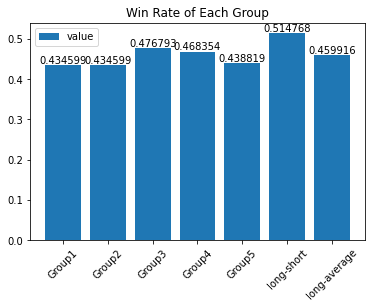

In [10]:
# 如果出现明显的分层, 则说明因子有良好的选股能力
report.group_return_ana(pred, y_test)

In [11]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "StrictTopKStrategy",  # 做多预测值前20%且值大于0.5%的股票, 做空后20%且值小于0.5%的股票. 自动平仓
        "kwargs": {
            "buy": 0.005,  # 手数随可用资金而改变，最大不会超过股票当天成交量的0.05%(例如T+1时下单，下单手数不会超过T时成交量的0.05%)
            "sell": -0.005,
            "auto_offset": True,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": True,  # =True时，只做多不做空(在A股做空有一定的难度)
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None  # 由于数据已经是以手为单位, 故无需二次处理
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

E(r): 0.16132751315921248
std: 0.05063713131582679
E(r_benchmark): -0.12867191898052116
std_benchmark: 0.05329655828798661 

Cumulative Rate of Return: 0.23776985396419215
Cumulative Rate of Return(benchmark): -0.1858229210189083
Cumulative Excess Rate of Return: 0.42359277498310044 

Max Drawdown: -0.07592159016521549
Max Drawdown(benchmark): -0.23197087771901204 

Sharpe Ratio: 3.1843297040800738
Information Ratio: 5.727011475649954 

Profitable Days(%): 0.9830508474576272


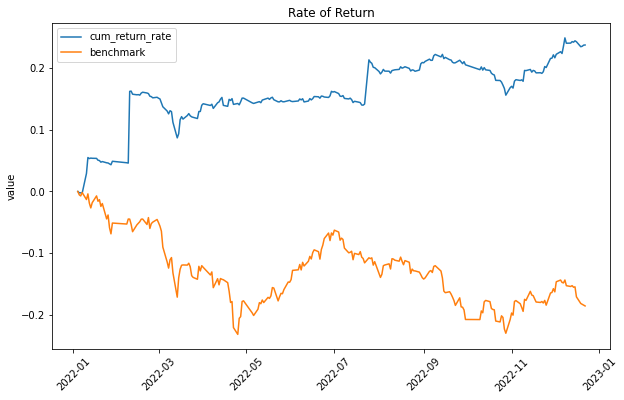

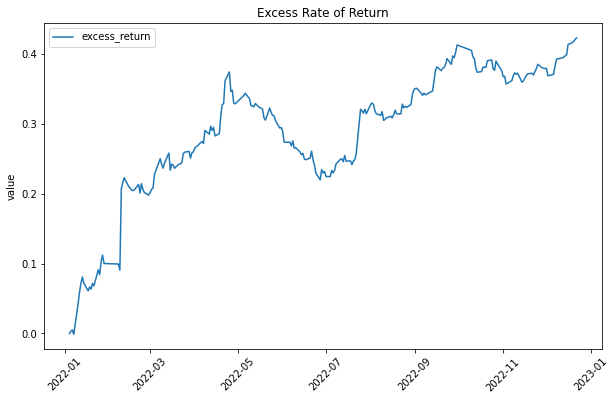

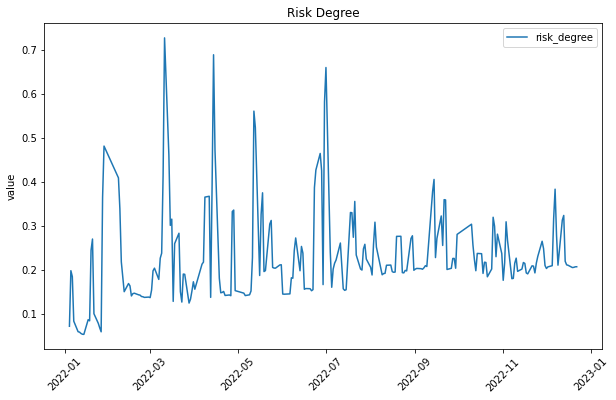

In [12]:
# 报告回测结果
# 对比2022年主动管理型基金的业绩，这表现算是在平均线以上
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节